# Plot Eval metrics

In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import joblib
import re
import seaborn as sns
from typing import Callable
from matplotlib.patches import Rectangle
import matplotlib as mpl
import numpy as np

# Apply the default theme
# sns.set_theme()
sns.set_style("whitegrid")
mpl.rcParams["figure.dpi"] = 150

import sys

sys.path.append("..")

from src.data.dataloader import (
    PromptLoader,
    GigawordDataLoader,
    DailymailDataLoader,
    TweetQADataLoader,
    RottenTomatoesDataLoader,
    MMLUAbstractAlgebraDataLoader,
    GSM8KDataLoader,
    MMLUHumanAgingDataLoader,
)
from src.utils.eval_metric import eval_gigaword, eval_dailymail, evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

load_dotenv()

True

In [2]:
def get_results(folder: Path, all_reference_data: list[str], iterative_dir: str = "iterative", use_cached: bool = True):
    pred_file = Path(folder) / iterative_dir / "predictions.json"
    if not pred_file.is_file():
        print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / iterative_dir / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=use_cached)

In [3]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b", "gpt3.5", "gpt4"],
    experiment_path=Path("../experiments/"),
    use_cached: bool = True
):
    results = []
    for model_folder in model_folder_names:
        eval_folder = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results in parallel for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for f in in_ctxt_folder.iterdir():
                try:
                    res.append(get_results(f, all_ref_data, use_cached=use_cached))
                except Exception as e:
                    print(f"Error processing {str(f)}")
                    print(e)

            # res = joblib.Parallel(n_jobs=1)(
            #     joblib.delayed(get_results)(f, all_ref_data)
            #     for f in in_ctxt_folder.iterdir()
            # )
            # Remove empty results
            res = [r for r in res if r]
            results.extend(res)
    return results

In [4]:
# Assign colors to incontext_set

# Load pastel colors
pastel_colors = sns.color_palette("Set2", 7)
print(pastel_colors)

dataset_color = {
    "tweetqa": pastel_colors[0],
    "gigaword": pastel_colors[1],
    "dailymail": pastel_colors[2],
    "rotten_tomatoes": pastel_colors[3],
    "mmluaa": pastel_colors[4],
    "gsm8k": pastel_colors[5],
    "mmlu-age": pastel_colors[6],
}

dataset_label = {
    "tweetqa": "TweetQA",
    "gigaword": "Gigaword",
    "dailymail": "Dailymail",
    "rotten_tomatoes": "Rotten Tomatoes",
    "mmluaa": "MMLU Abstract Algebra",
    "gsm8k": "GSM8K",
    "mmlu-age": "MMLU Human Aging",
}

model_label = {
    "mistral-7b": "Mistral-7B",
    "llama-7b": "LLAMA-7B",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "mixtral": "Mixtral",
}

# Assign linestyle to model
model_linestyle = {
    # "mistral-7b": "-",
    # "llama-7b": "--",
    # "gpt3.5": ":",
    # "gpt4": " ",
    # "mixtral": "-.",
    "model": "-",
}

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961), (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)]


In [5]:
def plot_dataset_models_legend(ax: plt.axes):
    """Create a tabular legend: rows are datasets, columns are models"""
    # create blank rectangle as a placeholder
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor="none", linewidth=0)

    # Top left corner of legend is blank
    legend_handles = [extra]
    legend_labels = [""]

    # First column is list of datasets
    for dataset in dataset_color.keys():
        legend_handles.append(extra)
        legend_labels.append(dataset)

    # Subsequent columns are for each model
    for model, style in model_linestyle.items():
        # Model name
        legend_handles.append(extra)
        legend_labels.append(model)
        for dataset, colour in dataset_color.items():
            (im,) = ax.plot([], [], linestyle=style, color=colour, marker="x")
            # Add line style to legend
            legend_handles.append(im)
            legend_labels.append("")

    ax.legend(
        legend_handles,
        legend_labels,
        ncols=len(model_linestyle) + 1,
        loc="lower left",
        bbox_to_anchor=(0, 0),
        handletextpad=-2,
    )

In [6]:
def plot_df_metrics(
    results_df: pd.DataFrame,
    metrics: list[str],
    save_path: Path = None,
    title: str = None,
    adjust_func: Callable = lambda _: _,
):
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    num_metrics = len(metrics)
    fig, axs = plt.subplots(
        figsize=(10, 4 * num_metrics), nrows=num_metrics, ncols=1, sharex=True
    )
    for idx, (metric, ax) in enumerate(zip(metrics, axs)):
        for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
            df = df.sort_values("num_examples")

            g = sns.lineplot(
                data=df,
                x="num_examples",
                y=metric,
                ax=ax,
                label=f"{model} {inctxt}",
                linestyle=model_linestyle[model],
                color=dataset_color[inctxt],
                marker="X",
            )
            ax.set_ylabel(metric)
            # Remove legend for all but last plot
            # if idx != num_metrics - 1:
                # ax.legend_.remove()
            ax.legend_.remove()

    # Add legend
    plot_dataset_models_legend(axs[0])

    axs[-1].set_xlabel("Number of examples")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    adjust_func(axs)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        # Also save as png
        plt.savefig(save_path.with_suffix(".png"), bbox_inches="tight")
    plt.show()

In [7]:
def plot_df_metrics_per_model(
  results_df: pd.DataFrame,
  metrics: list[str],
  save_path: Path = None,
  title: str = None,
  adjust_func: Callable = lambda _: _,
  eval_set: str = "",
  legend_anchor: tuple[float, float] = (0.95, 1.5),
  legend_axs = (-1, 0),
):
    """Plot metrics for each dataset and model
    
    axis per model
    line per dataset

    x-axis: number of examples
    y-axis: metric
    """
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    num_metrics = len(metrics)
    num_models = len(results_df["model"].unique())
    fig, axs = plt.subplots(
        figsize=(10, 3 * num_metrics), 
        nrows=num_metrics, 
        ncols=num_models, 
        sharex=True, 
        sharey='row', 
        squeeze=False,
    )

    for y_idx, (metric, axs_y) in enumerate(zip(metrics, axs)):
        for ax, (model, df) in zip(axs_y, results_df.groupby("model")):
            for (inctxt, df_inctxt) in df.groupby("incontext_set"):
                df_inctxt = df_inctxt.sort_values("num_examples")

                g = sns.lineplot(
                    data=df_inctxt,
                    x="num_examples",
                    y=metric,
                    ax=ax,
                    label=dataset_label[inctxt],
                    color=dataset_color[inctxt],
                    marker="X",
                )
                ax.set_ylabel(metric)
                if y_idx == 0:
                    ax.set_title(model_label[model])
                ax.legend_.remove()

            ax.set_xlim(0, 6)
            # ax.set_xlabel(r"History Length $L$")
            ax.set_xlabel("")

    # Add legend
    # plot_dataset_models_legend(axs[-1, 0])
    legend = axs[legend_axs].legend(
        loc="upper left", 
        bbox_to_anchor=legend_anchor, 
        ncol=len(results_df["incontext_set"].unique()) // 2,
        # nrow=2,
        fancybox=True,
        shadow=True,
    )
    legend.set_title("Conversation History Task")
    # Colour eval set label
    if eval_set:
        for text in legend.get_texts():
            if text.get_text() == dataset_label[eval_set]:
                # make bold
                # text.set_weight("bold")
                # text.set_color("red")
                text.set_text(rf"\textbf{{{text.get_text()}}}")
    if title:
        fig.suptitle(title)
    # plt.tight_layout()
    adjust_func(axs)
    fig.text(0.5, -0.05, r'Conversation History Length $L$', ha='center')
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        # Also save as png
        # plt.savefig(save_path.with_suffix(".png"), bbox_inches="tight")
    plt.show()
            

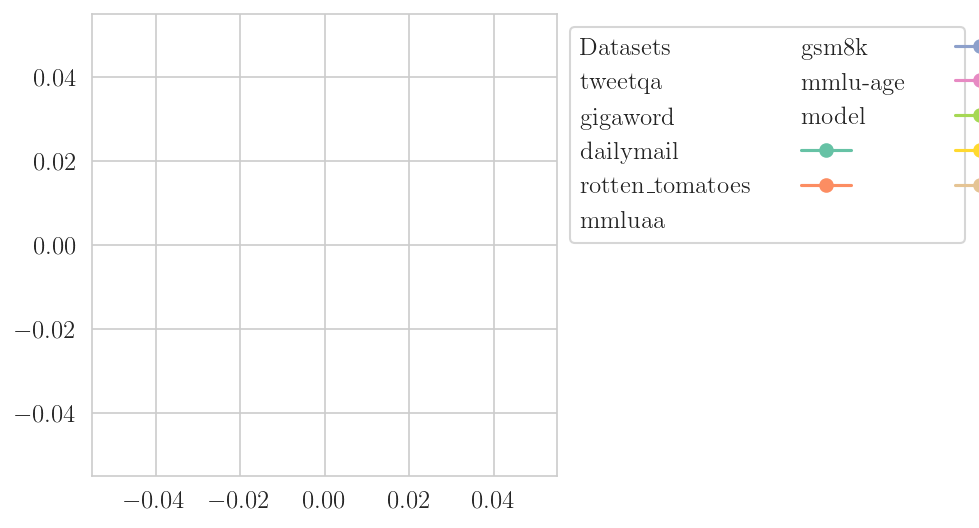

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))

# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor="none", linewidth=0)

# rows as datasets, columns as models
legend_handles = [extra]
legend_labels = ["Datasets"]

# First column is list of datasets
for dataset in dataset_color.keys():
    legend_handles.append(extra)
    legend_labels.append(dataset)

# Subsequent columns are for each model
for model, style in model_linestyle.items():
    # Model name
    legend_handles.append(extra)
    legend_labels.append(model)
    for dataset, colour in dataset_color.items():
        (im,) = ax.plot([], [], linestyle=style, color=colour, marker="o")
        legend_handles.append(im)
        legend_labels.append("")

ax.legend(
    legend_handles,
    legend_labels,
    ncols=3,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    handletextpad=-2,
)
plt.show()

In [9]:
def df_metric_pct_change(df: pd.DataFrame, metric: str):
    """Calculate the percentage change of a metric"""
    df[f"{metric}_pct_change"] = 0.
    for row in df[["model", "incontext_set", metric]].itertuples():
        baseline_metric = df[(df["model"] == row.model) & (df["incontext_set"] == row.incontext_set) & (df["num_examples"] == 0)][metric].values[0]
        df.loc[row.Index, f"{metric}_pct_change"] = (row[-1] - baseline_metric) / baseline_metric * 100
    return df

In [10]:
def sensitivity(df: pd.DataFrame):
    """Calculate the sensitivity of the model"""
    df["sensitivity"] = np.nan
    metric = "base_likelihood"
    for row in df[["model", "incontext_set", metric]].itertuples():
        baseline_metric = df[(df["model"] == row.model) & (df["num_examples"] == 0)][metric].values
        # filter nan
        baseline_metric = baseline_metric[~np.isnan(baseline_metric)]
        if len(baseline_metric) > 0:
            baseline_metric = baseline_metric[0]
        else:
            continue
        # print(baseline_metric)
        tau = np.exp(row.base_likelihood - baseline_metric)
        tau = 1 / tau
        df.loc[row.Index, "sensitivity"] = tau
    return df

In [11]:
def results_latex_table(df: pd.DataFrame, columns: list[str], task: str, num_examples: int = 5):
    """Print a dataframe as a latex table
    
    Args:
      df: dataframe
      columns: list of columns to include
      task: name of the task (this is printed as the first set of rows)

    Format:
      dataset | model | metric1 | metric2 | ...
    """
    # Sort datasets
    datasets = sorted(list(df["incontext_set"].unique()))
    datasets.remove(task)
    datasets = [task] + datasets

    # Print header
    print("CH-Task & Model & {" + "} & {".join(columns) + r"} \\")
    print(r"\midrule")

    for dataset in datasets:
        print(f"{dataset_label[dataset]} ")
        df_ds = df[df["incontext_set"] == dataset]
        for model, df_model in df_ds.groupby("model"):
            # print model
            print(f"& {model_label[model]} & ", end="")
            # filter by number of examples
            df_model = df_model[df_model["num_examples"] == num_examples]
            # extract relevant columns
            values = df_model[columns].values[0]
            # print values
            print(" & ".join(["{-}" if np.isnan(v) else f"{v:.2f}" for v in values]) + r" \\")
        if dataset != datasets[-1]:
            print(r"\midrule")
        if dataset == task:
            print(r"\midrule")

### Evaluate on MMLU Human Ageing

In [12]:
mmlu_age = MMLUHumanAgingDataLoader()
mmlu_age_ref_data = mmlu_age.load_test_reference()
mmlu_age_results = get_results_for_evalset("mmlu-age", mmlu_age_ref_data, use_cached=False)
mmlu_age_df = pd.DataFrame(mmlu_age_results)
mmlu_age_df.head()

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Removing large training set examples
Original training set size:  26
New Training set size:  26


Map:   0%|          | 0/222 [00:00<?, ? examples/s]

---Failed for Answer: 
: Reference: C, ['less than 25%', 'less than 50%', 'more than 75%']:
Prediction:  <Answer> </Answer>
---Failed for Answer: 
: Reference: D, ['older adults are almost always portrayed in a negative way', 'the more positive portrayals occur during commercials', 'the proportion of older men is particularly low']:
Prediction:  <Answer> </Answer>
---Failed for Answer: 
: Reference: B, ['20%', '50%', '75%']:
Prediction:  <Answer> </Answer>
---Failed for Answer: 
: Reference: C, ['less than 25%', 'less than 50%', 'more than 75%']:
Prediction:  <Answer> </Answer>
---Failed for Answer: 
: Reference: D, ['older adults are almost always portrayed in a negative way', 'the more positive portrayals occur during commercials', 'the proportion of older men is particularly low']:
Prediction:  <Answer> </Answer>
---Failed for Answer: 
: Reference: A, ['25%', '50%', '75%']:
Prediction: <Answer> </Answer>
---Failed for Answer: 
: Reference: B, ['20%', '50%', '75%']:
Prediction: <Answ

,matches,failed,total,model,incontext_set,num_examples,base_likelihood
0,137,1,222,mistral-7b,mmlu-age,3,-1.123342
1,138,2,222,mistral-7b,mmlu-age,6,-1.128903
2,123,0,222,mistral-7b,mmlu-age,0,-1.046391
3,140,1,222,mistral-7b,mmlu-age,4,-1.121651
4,135,1,222,mistral-7b,mmlu-age,2,-1.080061


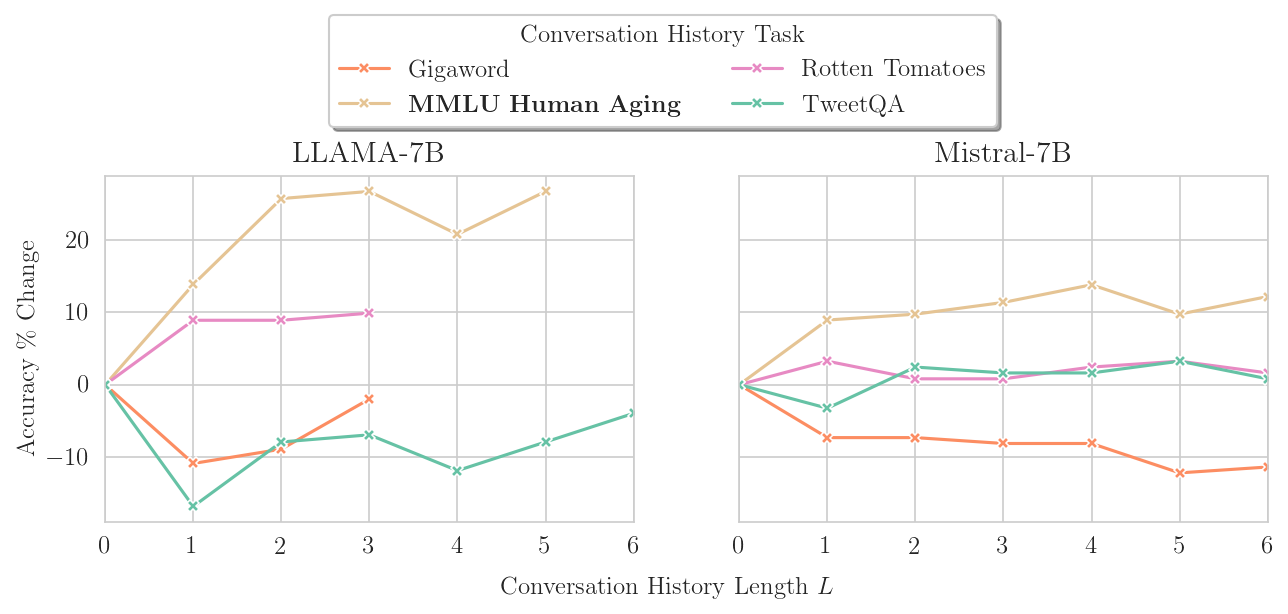

In [13]:
mmlu_age_df["acc"] = mmlu_age_df["matches"] / mmlu_age_df["total"]
mmlu_age_df = df_metric_pct_change(mmlu_age_df, "acc")
df = mmlu_age_df.rename(columns={"acc_pct_change": r"Accuracy \% Change"})
plot_df_metrics_per_model(
  df, 
  [r"Accuracy \% Change"], 
  # save_path=Path("mmluaa_accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmlu-age",
  legend_axs=(-1, 1),
  legend_anchor=(-0.8, 1.5),
)

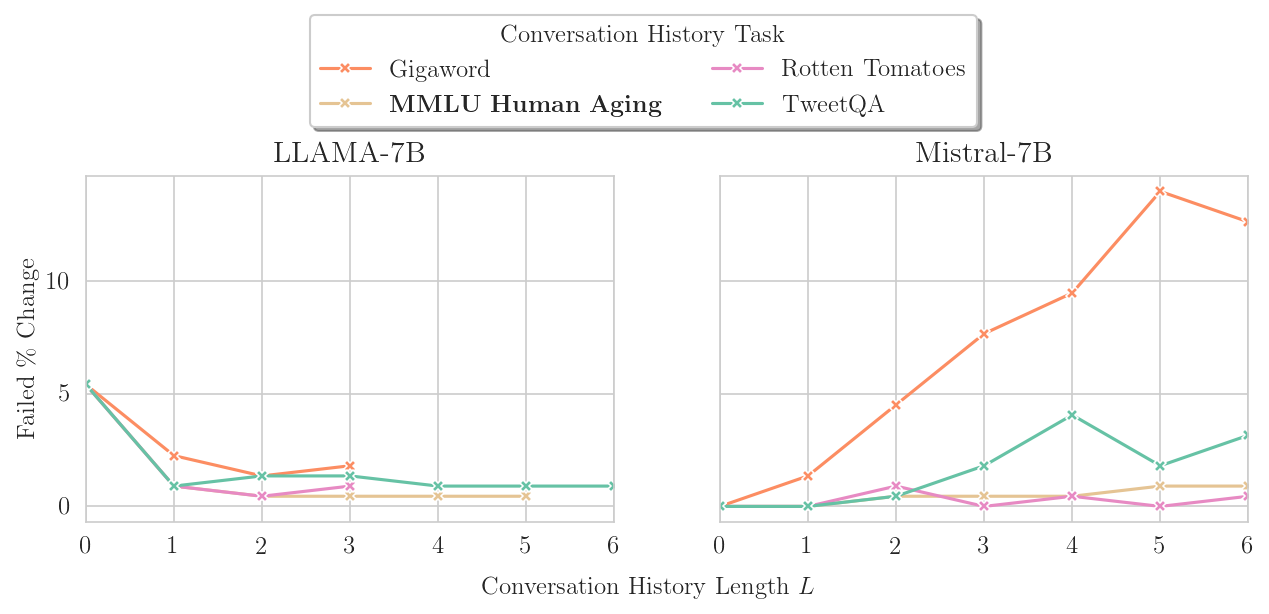

In [14]:
df = mmlu_age_df
df["perc_fail"] = df["failed"] / df["total"] * 100
df = df.rename(columns={"perc_fail": r"Failed \% Change"})
plot_df_metrics_per_model(
  df, 
  [r"Failed \% Change"], 
  # save_path=Path("mmluaa_accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmlu-age",
  legend_axs=(-1, 1),
  legend_anchor=(-0.8, 1.5),
)

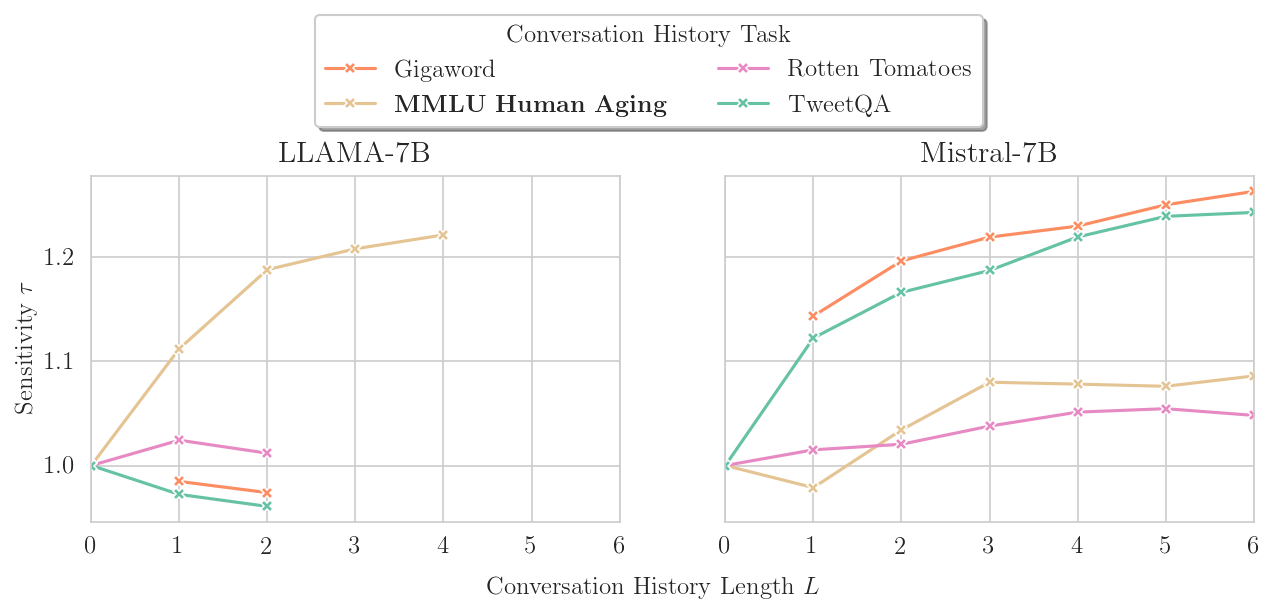

In [15]:
# aa_results_df["perc_fail"] = aa_results_df["failed"] / aa_results_df["total"] * 100
label = r"Sensitivity $\tau$"
df = mmlu_age_df
df = sensitivity(df)
df = df.rename(columns={"sensitivity": label})
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]
plot_df_metrics_per_model(
    df,
    [label],
    # save_path=Path("mmlu-age_sensitivity.pdf"),
    # title="MMLU Abstract Algebra Results",
    eval_set="mmlu-age",
    legend_axs=(-1, 1),
    legend_anchor=(-0.8, 1.5),
)

### Evaluate on GSM8K

In [32]:
gsm8k = GSM8KDataLoader()
gsm8k_ref_data = gsm8k.load_test_reference()
gsm8k_results = get_results_for_evalset("gsm8k", gsm8k_ref_data, use_cached=False)
gsm8k_results_df = pd.DataFrame(gsm8k_results)

gsm8k_results_df["acc"] = gsm8k_results_df["matches"] / gsm8k_results_df["total"]

gsm8k_results_df.head()

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

---Failed for Answer: 18/3
: Reference: 15
: Exception: could not convert string to float: '18/3'
---Failed for Answer: 8/7
: Reference: 8
: Exception: could not convert string to float: '8/7'
---Failed for Answer: 0.125+0.06666666666666667=0.19166666666666668
: Reference: 5
: Exception: could not convert string to float: '0.125+0.06666666666666667=0.19166666666666668'
---Failed for Answer: 72chairs68sofas
: Reference: 172
: Exception: could not convert string to float: '72chairs68sofas'
---Failed for Answer: Nosolution
: Reference: 300
: Exception: could not convert string to float: 'Nosolution'
---Failed for Answer: 3(x+7)
: Reference: 39
: Exception: could not convert string to float: '3(x+7)'
---Failed for Answer: x
: Reference: 80
: Exception: could not convert string to float: 'x'
---Failed for Answer: 64+48=112
: Reference: 112
: Exception: could not convert string to float: '64+48=112'
---Failed for Answer: 95.17glasses47.5plates
: Reference: 128
: Exception: could not convert 

,matches,failed,total,model,incontext_set,num_examples,base_likelihood,acc
0,537,48,1319,mistral-7b,gsm8k,3,None,0.407127
1,151,35,1319,mistral-7b,gsm8k,0,None,0.114481
2,525,48,1319,mistral-7b,gsm8k,2,None,0.398029
3,497,51,1319,mistral-7b,gsm8k,1,None,0.376801
4,133,36,1319,mistral-7b,tweetqa,3,None,0.100834


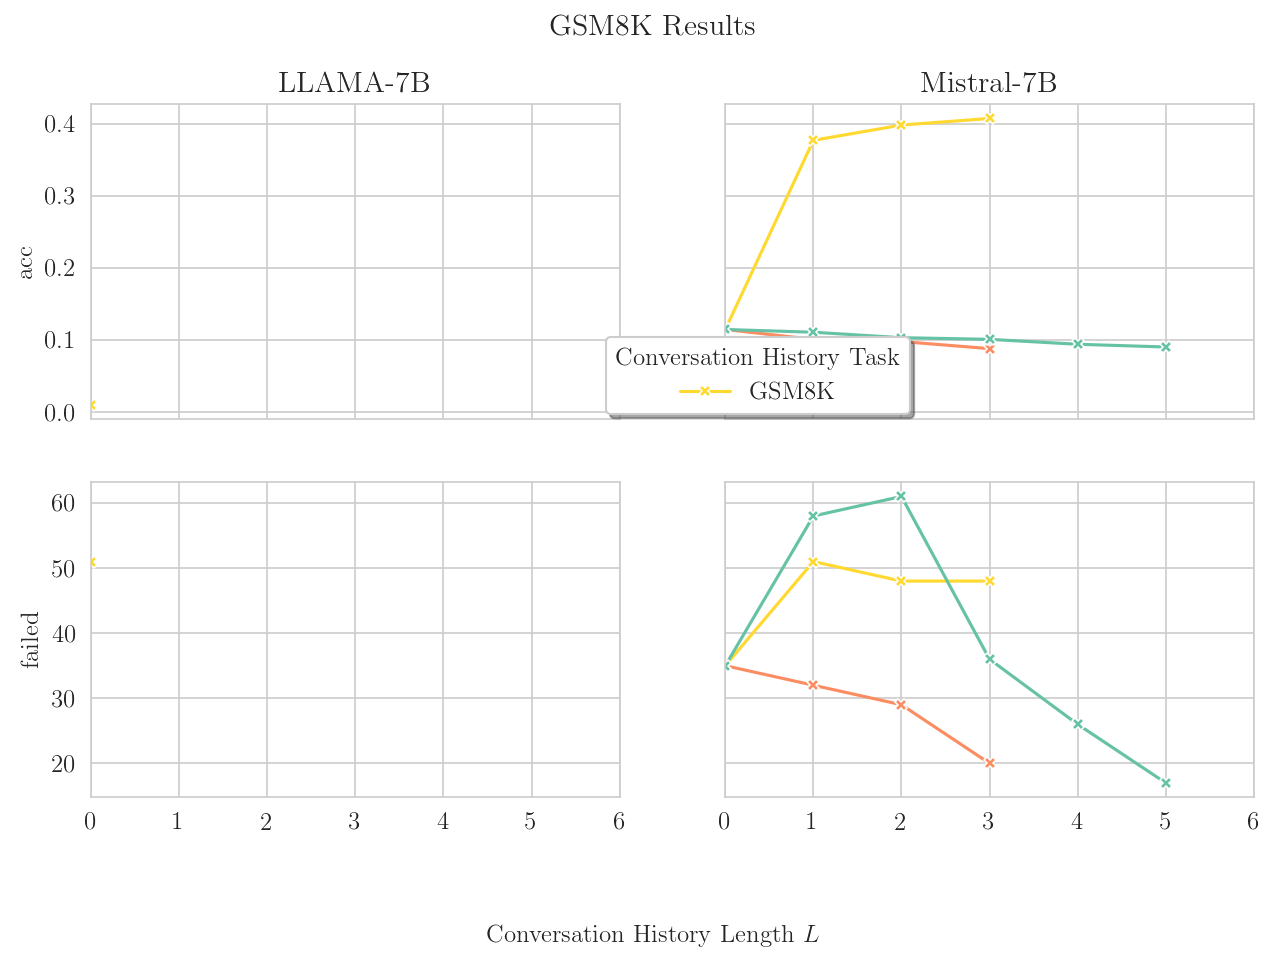

In [33]:
plot_df_metrics_per_model(
  gsm8k_results_df, 
  ["acc", "failed"], 
  save_path=Path("gsm8k_results.pdf"), 
  title="GSM8K Results",
)

## Evaluate on MMLUAA

In [34]:
aa = MMLUAbstractAlgebraDataLoader()
aa_ref_data = aa.load_test_reference()
aa_results = get_results_for_evalset("mmluaa", aa_ref_data, use_cached=False)
aa_results_df = pd.DataFrame(aa_results)
aa_results_df.head()

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

---Failed for Answer: a, true
: Reference: B, ['true, true', 'true, false', 'false, true']:
Prediction:  <Answer> A, True </Answer>
---Failed for Answer: a, true
: Reference: B, ['true, true', 'true, false', 'false, true']:
Prediction:  <Answer> A, True </Answer>
---Failed for Answer: a, b
: Reference: B, ['4z', '2z', 'z']:
Prediction:  <Answer> A, B </Answer>
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_mmluaa/num_examples_0/iterative/base_probabilities.pkl
---Failed for Answer: a, b
: Reference: B, ['4z', '2z', 'z']:
Prediction:  <Answer> A, B </Answer>
---Failed for Answer: a, b
: Reference: B, ['4z', '2z', 'z']:
Prediction:  <Answer> A, B </Answer>
---Failed for Answer: 
: Reference: C, ['8', '2', '120']:
Prediction:  <Answer> </Answer>
---Failed for Answer: 
: Reference: C, ['1', '2', '6']:
Prediction: <Answer> </Answer>
---Failed for Answer: 
: Reference: C, ['(1,1)', '(3,1)', '(3,6)']:
Prediction: <Answer> </Answer>
---Failed for

,matches,failed,total,model,incontext_set,num_examples,base_likelihood
0,23,1,99,mistral-7b,rotten_tomatoes,3,-1.169420
1,26,0,99,mistral-7b,rotten_tomatoes,6,-1.181519
2,22,0,99,mistral-7b,rotten_tomatoes,0,-1.126575
3,26,0,99,mistral-7b,rotten_tomatoes,4,-1.186017
4,24,0,99,mistral-7b,rotten_tomatoes,2,-1.148963


In [35]:
aa_results_df[aa_results_df["num_examples"] == 0]

,matches,failed,total,model,incontext_set,num_examples,base_likelihood
2,22,0,99,mistral-7b,rotten_tomatoes,0,-1.126575
9,21,0,99,mistral-7b,mmluaa,0,NaN
16,21,0,99,mistral-7b,tweetqa,0,-1.140825
22,21,0,99,mistral-7b,gigaword,0,-1.140825
29,32,1,99,llama-7b,rotten_tomatoes,0,-0.313764
36,28,3,99,llama-7b,mmluaa,0,NaN
43,28,3,99,llama-7b,tweetqa,0,-0.304926
50,28,3,99,llama-7b,gigaword,0,-0.304926
56,31,7,99,gpt3.5,rotten_tomatoes,0,NaN
62,31,7,99,gpt3.5,mmluaa,0,NaN


In [64]:
aa_results_df["acc"] = aa_results_df["matches"] / aa_results_df["total"]
aa_results_df = df_metric_pct_change(aa_results_df, "acc")
aa_results_df = sensitivity(aa_results_df)
aa_results_df.head()

,matches,failed,total,model,incontext_set,num_examples,base_likelihood,acc,acc_pct_change,sensitivity
0,23,1,99,mistral-7b,rotten_tomatoes,3,-1.169420,0.232323,4.545455,1.043775
1,26,0,99,mistral-7b,rotten_tomatoes,6,-1.181519,0.262626,18.181818,1.056481
2,22,0,99,mistral-7b,rotten_tomatoes,0,-1.126575,0.222222,0.000000,1.000000
3,26,0,99,mistral-7b,rotten_tomatoes,4,-1.186017,0.262626,18.181818,1.061244
4,24,0,99,mistral-7b,rotten_tomatoes,2,-1.148963,0.242424,9.090909,1.022640


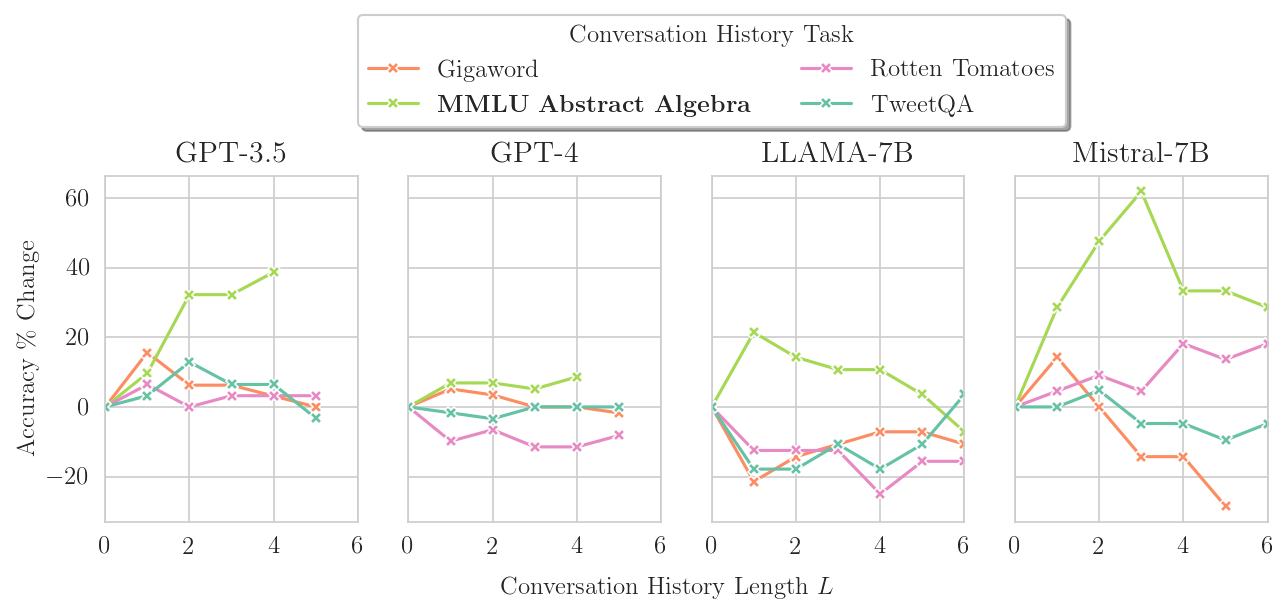

In [65]:
label = r"Accuracy \% Change"
df = aa_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("mmluaa_accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
)

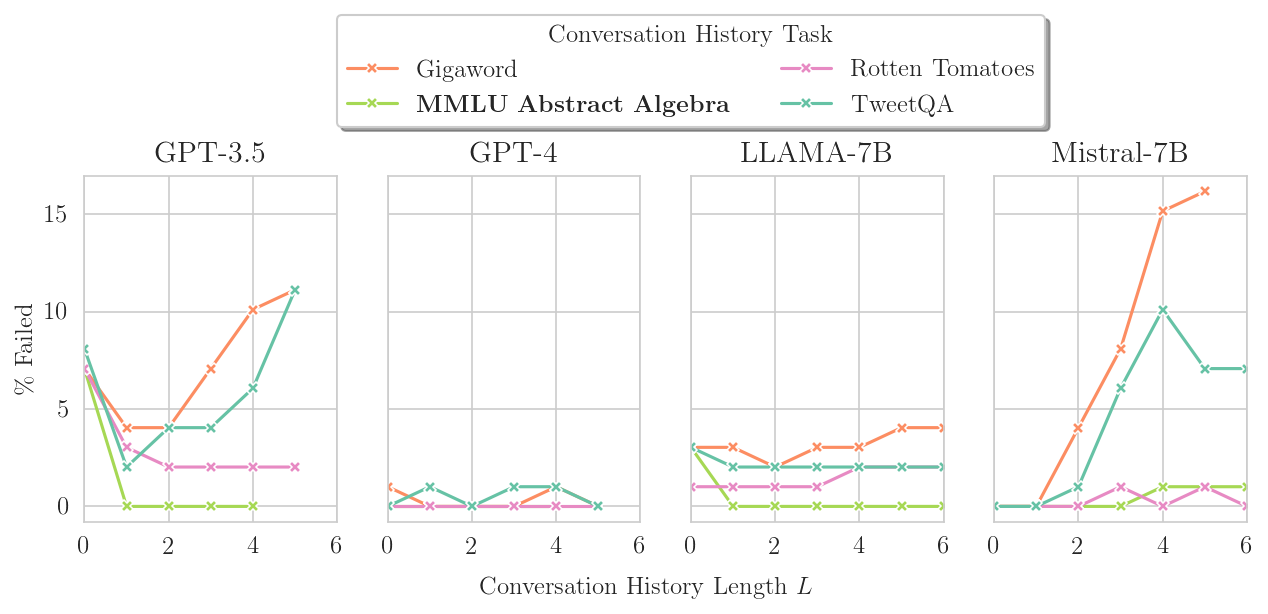

In [66]:
aa_results_df["perc_fail"] = aa_results_df["failed"] / aa_results_df["total"] * 100
df = aa_results_df.rename(columns={"perc_fail": r"\% Failed"})
plot_df_metrics_per_model(
  df, 
  [r"\% Failed"], 
  save_path=Path("mmlua_failed.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
)

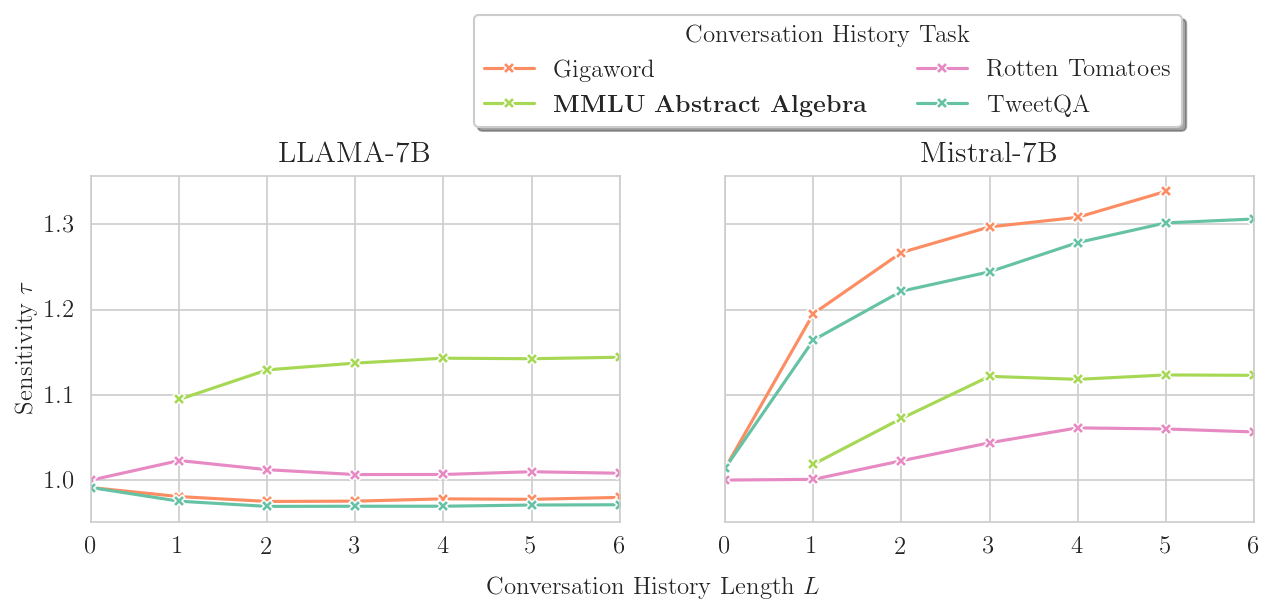

In [67]:
# aa_results_df["perc_fail"] = aa_results_df["failed"] / aa_results_df["total"] * 100
label = r"Sensitivity $\tau$"
df = aa_results_df.rename(columns={"sensitivity": label})
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("mmlua_sensitivity.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
  legend_anchor=(0.7, 1.5),
)

In [68]:
aa_results_df.columns

Index(['matches', 'failed', 'total', 'model', 'incontext_set', 'num_examples',
       'base_likelihood', 'acc', 'acc_pct_change', 'sensitivity', 'perc_fail'],
      dtype='object')

In [110]:
df = aa_results_df
df = df.rename(
    columns={
        r"sensitivity": r"$\tau(\cdot)$",
        r"acc_pct_change": r"\% Change",
    }
)
results_latex_table(df, [r"\% Change", r"$\tau(\cdot)$"], task="mmluaa", num_examples=3)

CH-Task & Model & {\% Change} & {$\tau(\cdot)$} \\
\midrule
MMLU Abstract Algebra 
& GPT-3.5 & 32.26 & {-} \\
& GPT-4 & 5.17 & {-} \\
& LLAMA-7B & 10.71 & 1.14 \\
& Mistral-7B & 61.90 & 1.12 \\
\midrule
\midrule
Gigaword 
& GPT-3.5 & 6.25 & {-} \\
& GPT-4 & 0.00 & {-} \\
& LLAMA-7B & -10.71 & 0.98 \\
& Mistral-7B & -14.29 & 1.30 \\
\midrule
Rotten Tomatoes 
& GPT-3.5 & 3.23 & {-} \\
& GPT-4 & -11.48 & {-} \\
& LLAMA-7B & -12.50 & 1.01 \\
& Mistral-7B & 4.55 & 1.04 \\
\midrule
TweetQA 
& GPT-3.5 & 6.45 & {-} \\
& GPT-4 & 0.00 & {-} \\
& LLAMA-7B & -10.71 & 0.97 \\
& Mistral-7B & -4.76 & 1.24 \\


In [13]:
aa_results_df[aa_results_df["base_likelihood"].notna()]

,matches,failed,total,model,incontext_set,num_examples,base_likelihood
0,34,0,99,mistral-7b,mmluaa,3,-13.655813
2,28,1,99,mistral-7b,mmluaa,4,-13.621037
3,31,0,99,mistral-7b,mmluaa,2,-13.160367
4,27,0,99,mistral-7b,mmluaa,1,-12.594403
5,20,6,99,mistral-7b,tweetqa,3,-14.797384
6,21,0,99,mistral-7b,tweetqa,0,-12.549076
7,20,10,99,mistral-7b,tweetqa,4,-15.095870
8,22,1,99,mistral-7b,tweetqa,2,-14.594365
9,19,7,99,mistral-7b,tweetqa,5,-15.293324
10,21,0,99,mistral-7b,tweetqa,1,-14.065586


## Evaluate on Rotten Tomatoes

In [46]:
rt = RottenTomatoesDataLoader()
rt_reference_data = rt.load_test_reference()
rt_results = get_results_for_evalset("rotten_tomatoes", rt_reference_data, use_cached=True)
rt_results_df = pd.DataFrame.from_records(rt_results)
rt_results_df.head()

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_8
Skipping ../experiments/gpt3.5/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_3
Skipping ../experiments/gpt3.5/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_10
Skipping ../experiments/gpt3.5/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_6
Skipping ../experiments/gpt3.5/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_4
Skipping 

,matches,failed,total,model,incontext_set,num_examples,baseline_likelihood
0,924,1,1066,mistral-7b,dailymail,0,NaN
1,892,1,1066,mistral-7b,dailymail,4,NaN
2,898,2,1066,mistral-7b,dailymail,2,NaN
3,970,0,1066,mistral-7b,rotten_tomatoes,10,-8.893913
4,959,2,1066,mistral-7b,rotten_tomatoes,6,-9.076649


In [47]:
# Calculate the percentage change in accuracy
rt_results_df["acc"] = rt_results_df["matches"] / rt_results_df["total"]
rt_results_df = df_metric_pct_change(rt_results_df, "acc")
rt_results_df.head()

,matches,failed,total,model,incontext_set,num_examples,baseline_likelihood,acc,acc_pct_change
0,924,1,1066,mistral-7b,dailymail,0,NaN,0.866792,0.000000
1,892,1,1066,mistral-7b,dailymail,4,NaN,0.836773,-3.463203
2,898,2,1066,mistral-7b,dailymail,2,NaN,0.842402,-2.813853
3,970,0,1066,mistral-7b,rotten_tomatoes,10,-8.893913,0.909944,4.978355
4,959,2,1066,mistral-7b,rotten_tomatoes,6,-9.076649,0.899625,3.787879


In [48]:
rt_results_df[rt_results_df["baseline_likelihood"].notna()]

,matches,failed,total,model,incontext_set,num_examples,baseline_likelihood,acc,acc_pct_change
3,970,0,1066,mistral-7b,rotten_tomatoes,10,-8.893913,0.909944,4.978355
4,959,2,1066,mistral-7b,rotten_tomatoes,6,-9.076649,0.899625,3.787879
5,924,1,1066,mistral-7b,rotten_tomatoes,0,-8.555469,0.866792,0.000000
6,956,1,1066,mistral-7b,rotten_tomatoes,4,-9.413556,0.896811,3.463203
7,943,0,1066,mistral-7b,rotten_tomatoes,2,-9.698779,0.884615,2.056277
8,968,1,1066,mistral-7b,rotten_tomatoes,8,-8.960191,0.908068,4.761905
9,908,0,1066,mistral-7b,tweetqa,10,-8.511220,0.851782,-1.731602
10,916,0,1066,mistral-7b,tweetqa,6,-8.470106,0.859287,-0.865801
11,924,1,1066,mistral-7b,tweetqa,0,-8.555469,0.866792,0.000000
12,905,0,1066,mistral-7b,tweetqa,4,-8.442212,0.848968,-2.056277


In [49]:
# Remove llama dailymail num examples 4
# rt_results_df = rt_results_df[
#     ~((rt_results_df["model"] == "llama-7b") & (rt_results_df["num_examples"] == 4) & (rt_results_df["incontext_set"] == "dailymail"))
# ]

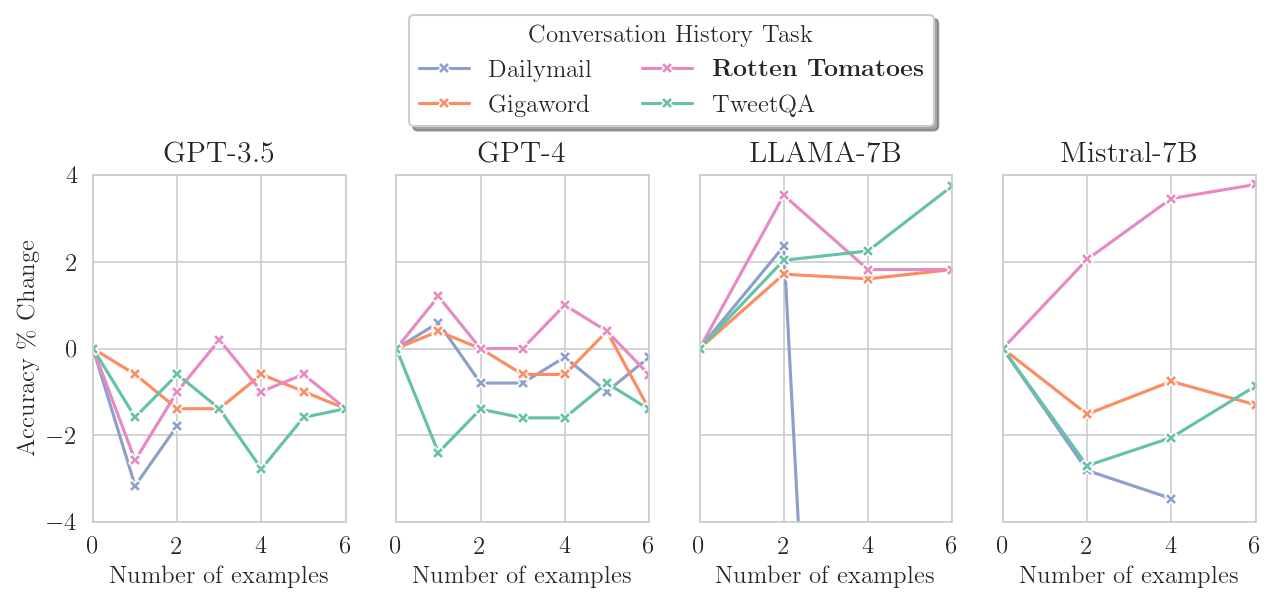

In [50]:
label = r"Accuracy \% Change"
df = rt_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("rt_accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="rotten_tomatoes",
  legend_anchor=(1.2, 1.5),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-4, 4),
)

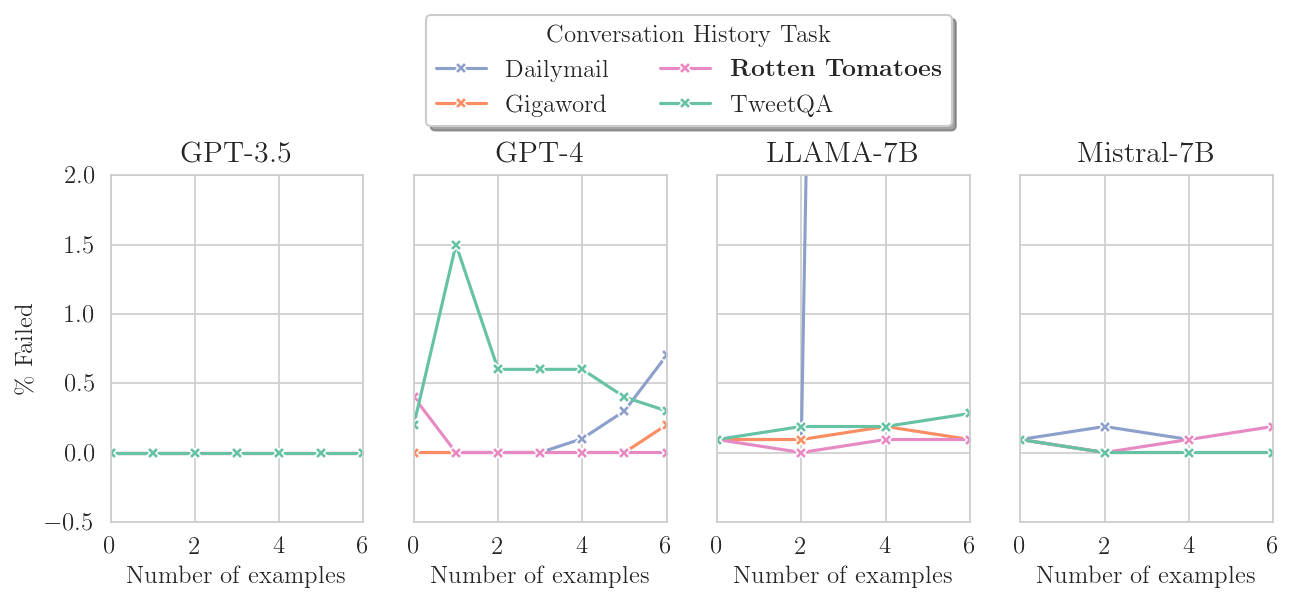

In [51]:
rt_results_df["perc_fail"] = rt_results_df["failed"] / rt_results_df["total"] * 100
df = rt_results_df.rename(columns={"perc_fail": r"\% Failed"})
plot_df_metrics_per_model(
  df, 
  [r"\% Failed"], 
  save_path=Path("rt_failed.pdf"), 
  eval_set="rotten_tomatoes",
  legend_anchor=(1.2, 1.5),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-0.5, 2),
)

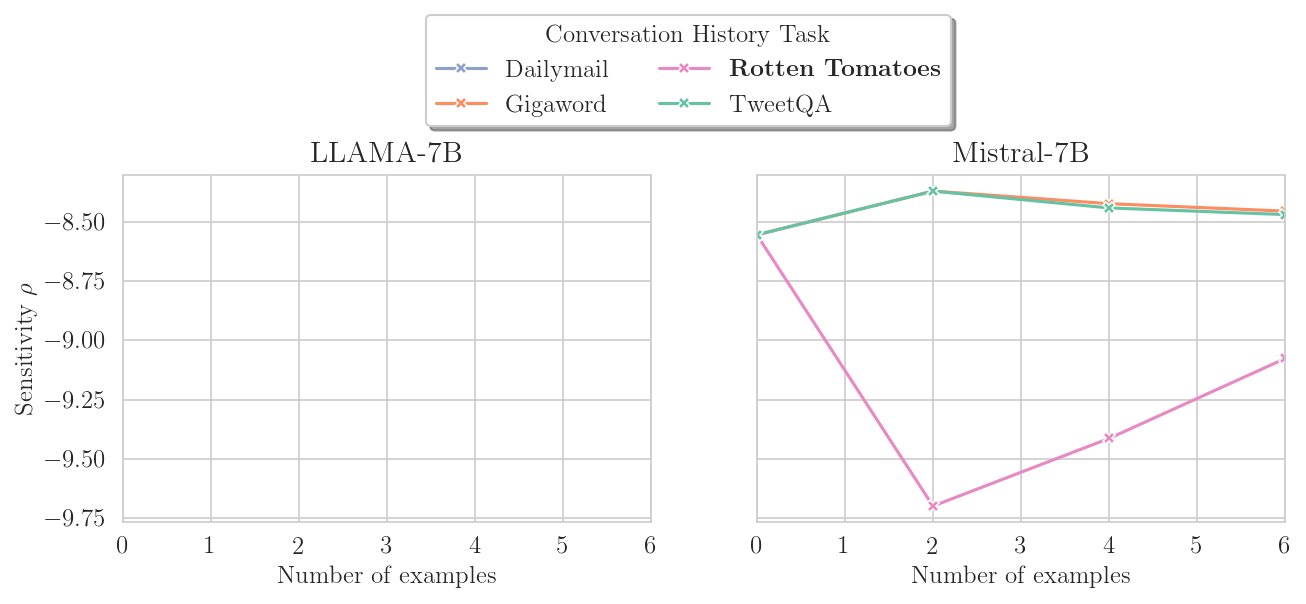

In [52]:
label = r"Sensitivity $\rho$"
df = rt_results_df.rename(columns={"baseline_likelihood": label})
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("rt_sensitivity.pdf"), 
  eval_set="rotten_tomatoes",
  legend_anchor=(0.55, 1.5),
)

## Evaluate on TweetQA

In [60]:
tq = TweetQADataLoader()
tq_reference_data = tq.load_test_reference()
tq_results = get_results_for_evalset("tweetqa", tq_reference_data, use_cached=True)
# convert to dataframe
tq_results_df = pd.DataFrame.from_records(tq_results)
# df = df.sort_values("num_examples")
tq_results_df.head()

Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_7
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_9
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_5
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/nu

,rouge1,rouge2,rougeL,rougeLsum,meteor,model,incontext_set,num_examples,baseline_likelihood
0,0.279779,0.146632,0.277754,0.277629,0.427295,mistral-7b,dailymail,3,NaN
1,0.252214,0.125869,0.249904,0.249707,0.407057,mistral-7b,dailymail,0,NaN
2,0.280630,0.145085,0.278293,0.278453,0.425253,mistral-7b,dailymail,4,NaN
3,0.284121,0.145772,0.281536,0.282060,0.429017,mistral-7b,dailymail,2,NaN
4,0.279370,0.141042,0.277093,0.277608,0.426147,mistral-7b,dailymail,5,NaN


In [61]:
tq_results_df[tq_results_df["num_examples"]==0]

,rouge1,rouge2,rougeL,rougeLsum,meteor,model,incontext_set,num_examples,baseline_likelihood
1,0.252214,0.125869,0.249904,0.249707,0.407057,mistral-7b,dailymail,0,NaN
8,0.252214,0.125869,0.249904,0.249707,0.407057,mistral-7b,rotten_tomatoes,0,-1.795089
15,0.252214,0.125869,0.249904,0.249707,0.407057,mistral-7b,tweetqa,0,NaN
25,0.252214,0.125869,0.249904,0.249707,0.407057,mistral-7b,gigaword,0,NaN
30,0.178765,0.087552,0.176427,0.176603,0.338442,llama-7b,dailymail,0,NaN
36,0.178765,0.087552,0.176427,0.176603,0.338442,llama-7b,rotten_tomatoes,0,NaN
42,0.178765,0.087552,0.176427,0.176603,0.338442,llama-7b,tweetqa,0,NaN
48,0.178765,0.087552,0.176427,0.176603,0.338442,llama-7b,gigaword,0,NaN


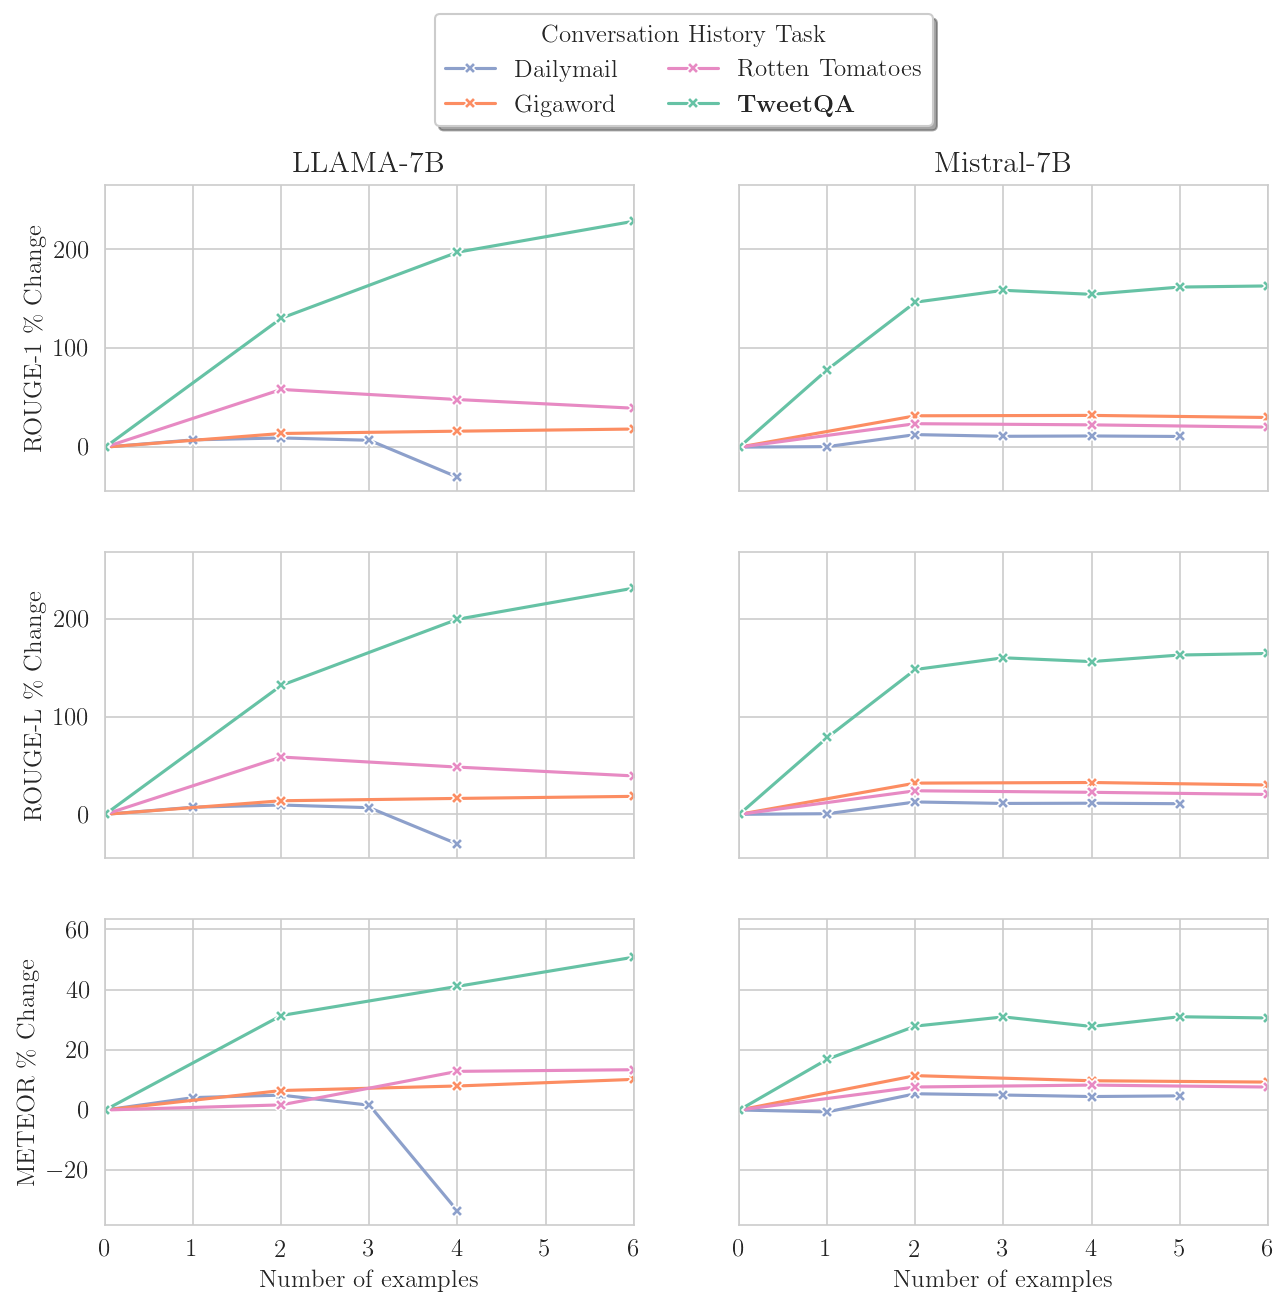

In [53]:
# Plot percentage change in metrics

df = tq_results_df

df = df_metric_pct_change(df, "rouge1")
df = df_metric_pct_change(df, "rougeL")
df = df_metric_pct_change(df, "meteor")

labels = {
    "rouge1_pct_change": r"ROUGE-1 \% Change",
    "rougeL_pct_change": r"ROUGE-L \% Change",
    "meteor_pct_change": r"METEOR \% Change",
}

df = df.rename(columns=labels)
plot_df_metrics_per_model(
  df, 
  labels.values(), 
  save_path=Path("tq_metrics.pdf"), 
  eval_set="tweetqa",
  legend_anchor=(0.6, 1.6),
  # adjust_func=lambda axs: axs[0, 0].set_ylim(-4, 4),
  legend_axs=(0,0)
)

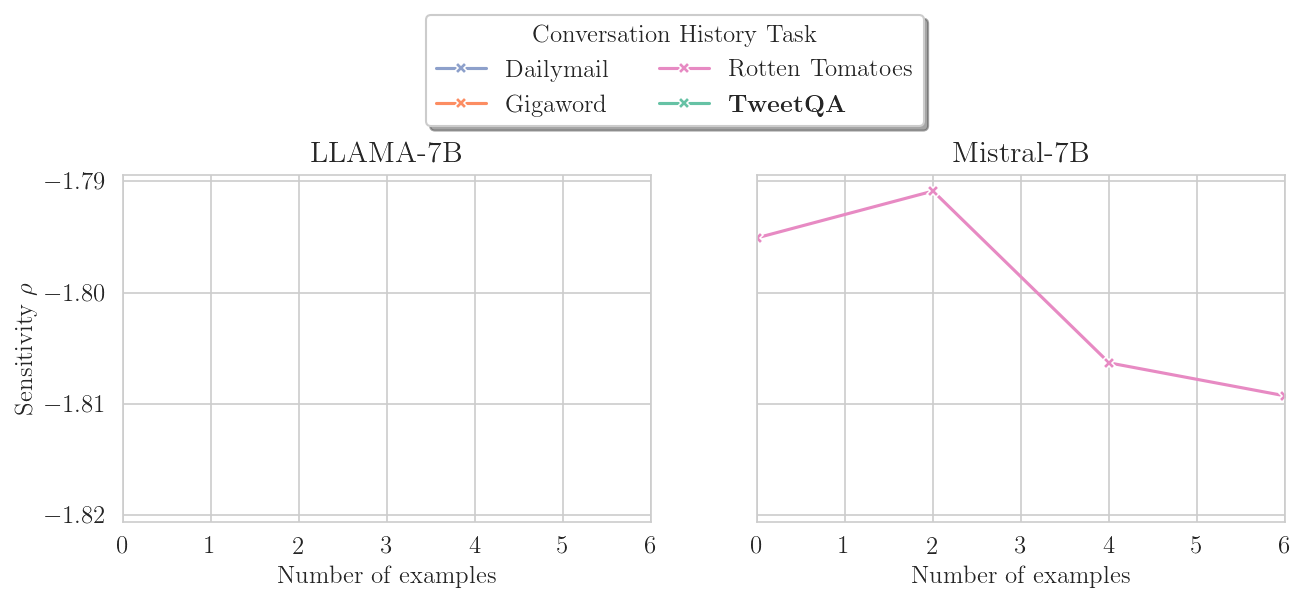

In [54]:
# Plot sensitivity rho

label = r"Sensitivity $\rho$"
df = tq_results_df.rename(columns={"baseline_likelihood": label})
# Remove gpt3.5, gpt4
df = df[~df["model"].isin(["gpt3.5", "gpt4"])]
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("tq_sensitivity.pdf"), 
  eval_set="tweetqa",
  legend_anchor=(0.55, 1.5),
  legend_axs=(0,0)
)

## Evaluate on Dailymail Set

In [28]:
dm = DailymailDataLoader()
dm_reference_data = dm.load_test_reference()
dm_results = get_results_for_evalset("dailymail", dm_reference_data, use_cached=True)
# convert to dataframe
dm_results_df = pd.DataFrame.from_records(dm_results)
# df = df.sort_values("num_examples")
dm_results_df.head()


Removing large training set examples
Original training set size:  287113
New Training set size:  258269
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_5
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_3
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_7
Skipping ../experiments/llama-7b/eval_data_dail

,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples
0,0.093224,0.003662,0.067809,0.080595,813.963,mistral-7b,dailymail,3
1,0.093699,0.003405,0.069112,0.081602,881.994,mistral-7b,dailymail,6
2,0.091363,0.003634,0.067305,0.078851,778.065,mistral-7b,dailymail,0
3,0.093627,0.003601,0.068690,0.081612,887.419,mistral-7b,dailymail,4
4,0.091660,0.003621,0.067545,0.079598,909.117,mistral-7b,dailymail,2


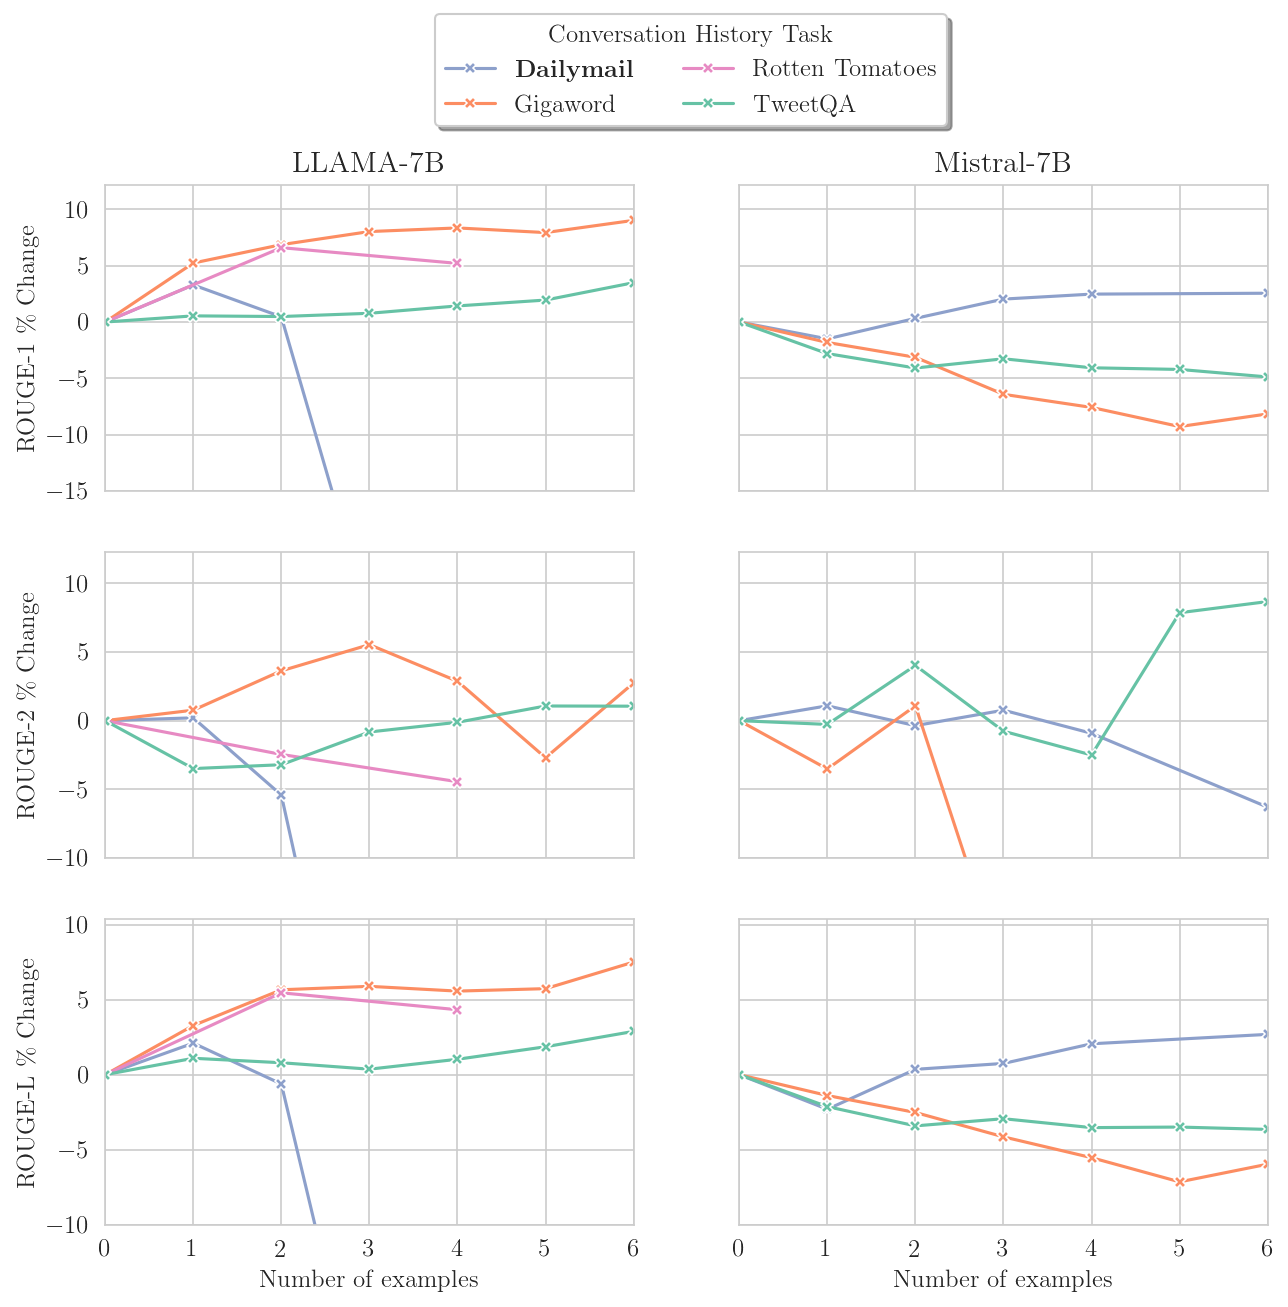

In [55]:
# Plot percentage change in metrics

df = dm_results_df

df = df_metric_pct_change(df, "rouge1")
df = df_metric_pct_change(df, "rouge2")
df = df_metric_pct_change(df, "rougeL")

labels = {
    "rouge1_pct_change": r"ROUGE-1 \% Change",
    "rouge2_pct_change": r"ROUGE-2 \% Change",
    "rougeL_pct_change": r"ROUGE-L \% Change",
}

df = df.rename(columns=labels)
plot_df_metrics_per_model(
  df, 
  labels.values(), 
  save_path=Path("dm_metrics.pdf"), 
  eval_set="dailymail",
  legend_anchor=(0.6, 1.6),
  adjust_func=lambda axs: (
    axs[0, 0].set_ylim(-15, None), 
    axs[1, 0].set_ylim(-10, None), 
    axs[2, 0].set_ylim(-10, None)
  ), 
  legend_axs=(0,0)
)

## Gigaword set

In [57]:
gw = GigawordDataLoader()
gw_reference_data = gw.load_test_reference()
gw_results = get_results_for_evalset("gigaword", gw_reference_data, use_cached=True)

Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_8
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_gigaword/num_examples_14
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_gigaword/num_examples_12
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_gigaword/num_examples_15
Skipping ../experiments/llama-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_gigaword/incontext_

In [58]:
gw_results_df = pd.DataFrame.from_records(gw_results)
print(len(gw_results_df))
gw_results_df.head()

97


,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples,baseline_likelihood
0,0.208274,0.064150,0.180788,0.180878,176.746797,mistral-7b,dailymail,3,NaN
1,0.185754,0.051918,0.158112,0.158233,203.721681,mistral-7b,dailymail,0,NaN
2,0.209893,0.065175,0.182368,0.182390,172.145054,mistral-7b,dailymail,4,NaN
3,0.206505,0.064255,0.178675,0.178962,177.343414,mistral-7b,dailymail,2,NaN
4,0.211351,0.066501,0.183804,0.183850,169.700666,mistral-7b,dailymail,5,NaN


In [59]:
gw_results_df[gw_results_df["num_examples"] == 0]

,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples,baseline_likelihood
1,0.185754,0.051918,0.158112,0.158233,203.721681,mistral-7b,dailymail,0,NaN
8,0.185754,0.051918,0.158112,0.158233,203.721681,mistral-7b,rotten_tomatoes,0,-1.014592
15,0.185754,0.051918,0.158112,0.158233,203.721681,mistral-7b,tweetqa,0,NaN
26,0.185785,0.051944,0.158127,0.158251,203.422860,mistral-7b,gigaword,0,NaN
34,0.114214,0.030880,0.097423,0.097823,481.321886,llama-7b,dailymail,0,NaN
38,0.114214,0.030880,0.097423,0.097823,481.321886,llama-7b,rotten_tomatoes,0,NaN
45,0.114214,0.030880,0.097423,0.097823,481.321886,llama-7b,tweetqa,0,NaN
55,0.116030,0.031323,0.098853,0.099347,435.170169,llama-7b,gigaword,0,NaN
59,0.173295,0.047776,0.147426,0.147356,222.132240,gpt3.5,dailymail,0,NaN
67,0.172856,0.047680,0.147141,0.147106,221.797027,gpt3.5,rotten_tomatoes,0,NaN


In [32]:
# Remove gpt3.5 rotten tomatoes
gw_results_df = gw_results_df[
    ~((gw_results_df["model"] == "gpt3.5") & (gw_results_df["incontext_set"] == "rotten_tomatoes"))
]

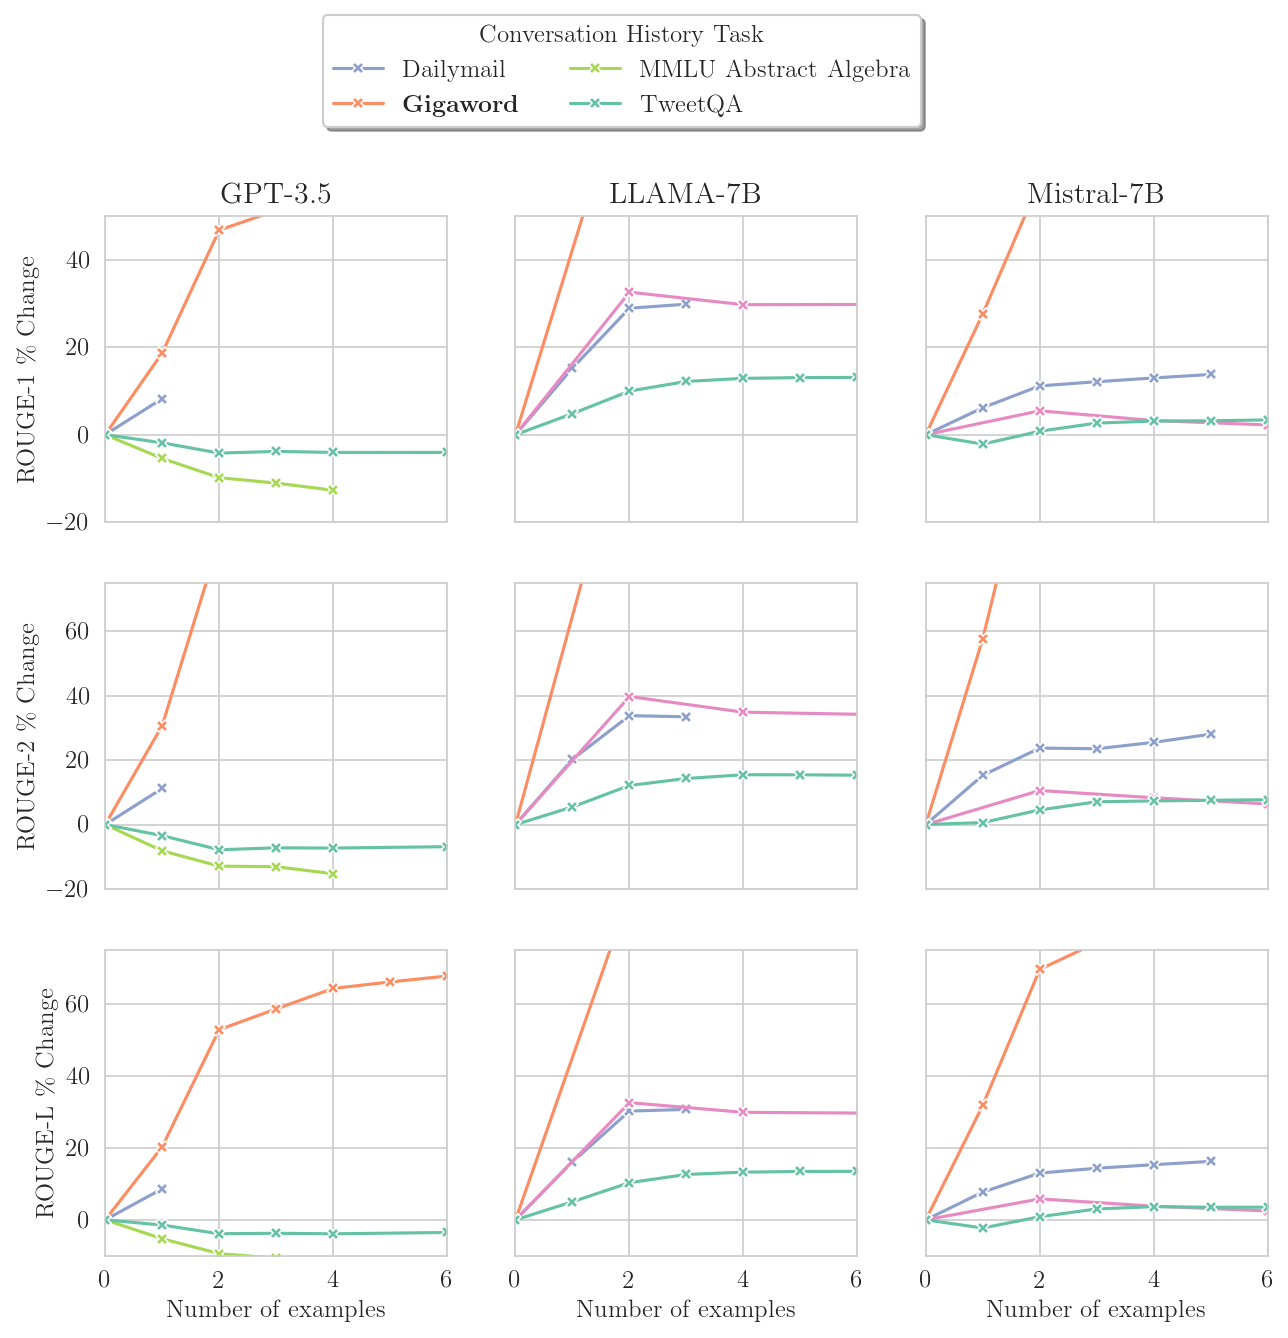

In [58]:
# Plot percentage change in metrics

df = gw_results_df

df = df_metric_pct_change(df, "rouge1")
df = df_metric_pct_change(df, "rouge2")
df = df_metric_pct_change(df, "rougeL")

labels = {
    "rouge1_pct_change": r"ROUGE-1 \% Change",
    "rouge2_pct_change": r"ROUGE-2 \% Change",
    "rougeL_pct_change": r"ROUGE-L \% Change",
}

df = df.rename(columns=labels)
plot_df_metrics_per_model(
  df, 
  labels.values(), 
  save_path=Path("gw_metrics.pdf"), 
  eval_set="gigaword",
  legend_anchor=(0.6, 1.7),
  adjust_func=lambda axs: (
    axs[0, 0].set_ylim(-20, 50), 
    axs[1, 0].set_ylim(-20, 75), 
    axs[2, 0].set_ylim(-10, 75)
  ), 
  legend_axs=(0,0)
)

In [263]:
len(gw_results_df[gw_results_df["baseline_likelihood"].notna()])

1

## .idea

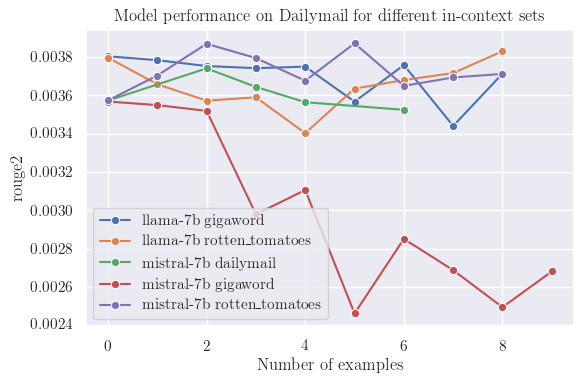

In [7]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

metric = "rouge2"

for (model, inctxt), df in dm_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Dailymail for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("dailymail-model-inctxt.png")
plt.show()

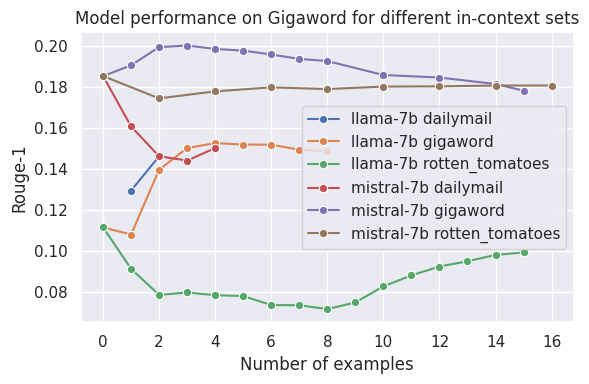

In [13]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y="rouge1",
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel("Rouge-1")
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

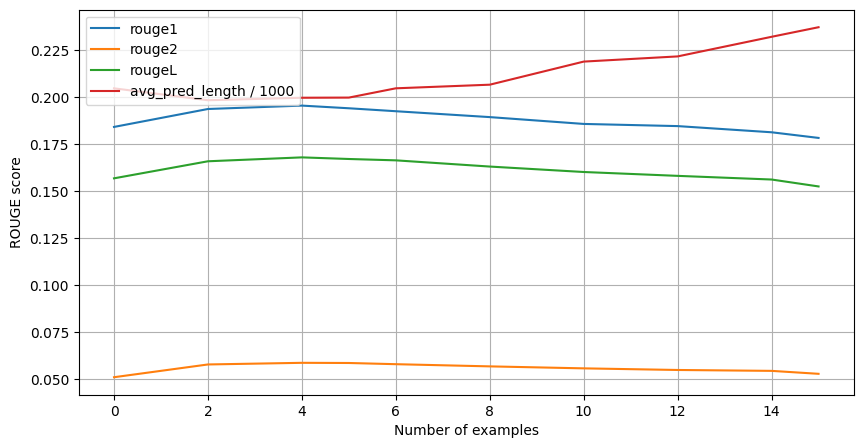

In [56]:
# Plot the results

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["num_examples"], df["rouge1"], label="rouge1")
ax.plot(df["num_examples"], df["rouge2"], label="rouge2")
ax.plot(df["num_examples"], df["rougeL"], label="rougeL")
ax.plot(df["num_examples"], df["avg_pred_length"] / 1000, label="avg_pred_length / 1000")
ax.set_xlabel("Number of examples")
ax.set_ylabel("ROUGE score")
ax.legend()
ax.grid()
fig.savefig("gigaword.png")
plt.show()

### Test evaluate

In [ ]:
pred_path = "/home/ag2118/rds/hpc-work/inctxt/inctxt/experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_0/iterative/predictions.json"

eval_idxs_file = Path(pred_path).parent / "eval_idxs.json"
if eval_idxs_file.is_file():
    ref_data = [dm_reference_data[i] for i in json.load(open(eval_idxs_file))]
else:
    ref_data = dm_reference_data
evaluate(pred_path, ref_data, use_cached=True)